In [61]:
from requests import Session
from requests_cache import CacheMixin, SQLiteCache
from requests_ratelimiter import LimiterMixin, MemoryQueueBucket
from pyrate_limiter import Duration, RequestRate, Limiter
class CachedLimiterSession(CacheMixin, LimiterMixin, Session):
    pass

session = CachedLimiterSession(
    limiter=Limiter(RequestRate(2, Duration.SECOND*5)),  # max 2 requests per 5 seconds
    bucket_class=MemoryQueueBucket,
    backend=SQLiteCache("yfinance.cache"),
)
session.headers['User-agent'] = 'n.finance/1.0'

In [62]:
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf

tickers = yf.Tickers(['2330.TW', '2882.TW', '2382.TW', '2317.TW', '2454.TW', '1101.TW'], session=session)

In [63]:
from typing import cast

# Extract every close price of each stock
close_data = pd.concat((cast(pd.DataFrame, ticker.history(period='1y', auto_adjust=False))["Close"].to_frame(id + ".CLOSE") for id, ticker in tickers.tickers.items()), axis=1)
close_data.index = close_data.index.date


In [64]:
tickers.tickers['2382.TW'].history(start='2019-01-01', auto_adjust=False)

,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits
Date,,,,,,,,
2019-01-02 00:00:00+08:00,53.000000,53.000000,52.099998,52.099998,37.966984,4213011,0.0,0.0
2019-01-03 00:00:00+08:00,52.299999,52.700001,51.799999,52.500000,38.258476,4913571,0.0,0.0
2019-01-04 00:00:00+08:00,51.799999,52.500000,51.200001,52.000000,37.894112,6337211,0.0,0.0
2019-01-07 00:00:00+08:00,52.799999,53.000000,52.000000,52.500000,38.258476,10231318,0.0,0.0
2019-01-08 00:00:00+08:00,52.599998,53.000000,52.500000,52.799999,38.477100,7578712,0.0,0.0
...,...,...,...,...,...,...,...,...
2023-11-21 00:00:00+08:00,216.000000,219.000000,215.000000,217.500000,217.500000,48092999,0.0,0.0
2023-11-22 00:00:00+08:00,212.000000,213.500000,208.000000,208.500000,208.500000,44246302,0.0,0.0
2023-11-23 00:00:00+08:00,208.000000,209.500000,203.000000,203.500000,203.500000,34825618,0.0,0.0


In [65]:
type(close_data["2330.TW.CLOSE"]), type(close_data.index)

(pandas.core.series.Series, pandas.core.indexes.base.Index)

In [66]:
close_data

,2330.TW.CLOSE,2882.TW.CLOSE,2382.TW.CLOSE,2317.TW.CLOSE,2454.TW.CLOSE,1101.TW.CLOSE
2022-11-28,480.5,42.000000,70.500000,100.0,703.0,33.000000
2022-11-29,487.0,43.450001,71.500000,100.0,713.0,33.549999
2022-11-30,490.0,43.549999,71.599998,100.5,733.0,33.900002
2022-12-01,498.5,43.468548,72.199997,103.0,741.0,34.049999
2022-12-02,492.5,43.320862,72.099998,105.5,739.0,33.650002
...,...,...,...,...,...,...
2023-11-21,585.0,46.150002,217.500000,102.5,926.0,34.200001
2023-11-22,577.0,46.299999,208.500000,102.0,942.0,33.849998
2023-11-23,578.0,46.299999,203.500000,101.5,930.0,34.000000
2023-11-24,575.0,46.299999,203.500000,101.5,945.0,33.750000


In [67]:
from numpy import ndarray
import ffn
import pandas as pd
import pandas_montecarlo

hw2_dataset = pd.DataFrame(
    index=["報酬", "風險（標準差）", "風險（下檔風險）", "風險（風險值）"],
)

def cal_half_dev(returns: ndarray) -> float:
    """計算下檔風險"""
    mu = returns.mean()
    returns_lower_than_mu = returns[returns < mu]
    helf_deviation = (sum((mu-returns_lower_than_mu)**2)/len(returns))**0.5

    return helf_deviation

for id, ticker in tickers.tickers.items():
    # Get the name of this stock.
    name = ticker.info["longName"]
    close = close_data[id + ".CLOSE"]

    # Simple return.
    simple_ret = ffn.to_returns(close)
    # Cumulative return.
    cum_ret = (1 + simple_ret).cumprod() - 1

    # 計算股市收盤指數標準差（風險）
    std = simple_ret.std()

    # 計算下檔風險
    half_dev = cal_half_dev(simple_ret)

    # 計算風險值 using Monte Carlo
    mc = simple_ret.montecarlo(sims=100, bust=-0.1, goal=1)
    risk_value = mc.maxdd['mean']

    # 將數據插入 dataset
    hw2_dataset[id] = [cum_ret.mean(), std, half_dev, risk_value]

hw2_dataset.transpose()


,報酬,風險（標準差）,風險（下檔風險）,風險（風險值）
2330.TW,0.108343,0.014841,0.009640,-0.084444
2882.TW,0.041581,0.010634,0.007275,-0.063098
2382.TW,1.083973,0.032236,0.022274,-0.079469
2317.TW,0.042209,0.011791,0.008303,-0.089813
2454.TW,0.047852,0.020695,0.014379,-0.095781
1101.TW,0.089362,0.011116,0.007503,-0.078055


In [68]:
# Calaulate the return value.
for key, values in close_data.items():
    if key.endswith(".CLOSE"):
        k = key[:-6]
        close_data[k+".SRETURN"] = ffn.to_returns(values)
        close_data[k+".CRETURN"] = (1 + close_data[k+".SRETURN"]).cumprod() - 1

# Clean up NaN values.
close_data = close_data.dropna()

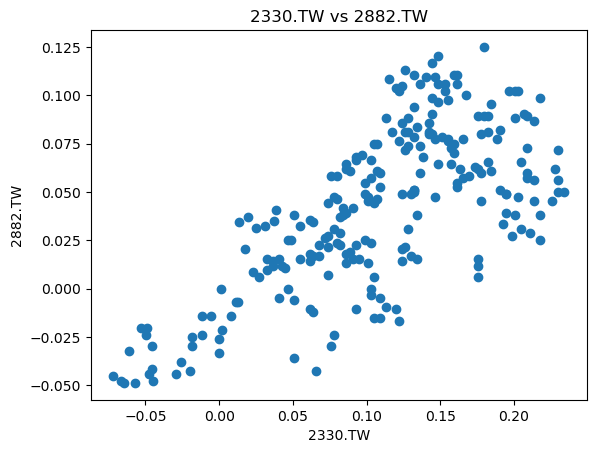

In [69]:
import matplotlib.pyplot as plt

plt.scatter(close_data["2330.TW.CRETURN"], close_data["2882.TW.CRETURN"])
plt.title("2330.TW vs 2882.TW")
plt.xlabel("2330.TW")
plt.ylabel("2882.TW")
plt.show()

In [70]:
# 回歸
import statsmodels.api as sm
from IPython.display import display, Markdown, Latex

ols = []
base = "2330.TW.CRETURN"

for key, values in close_data.items():
    if not str(key).endswith(".CRETURN"):
        continue

    display(Markdown(f"**Regression for {key} compared to {base}**"))
    result = sm.OLS(close_data[base], sm.add_constant(close_data[key])).fit()
    display(result.summary())
    # fig, ax = plt.subplots(figsize=(8,6))
    # ax.plot(close_data.index, close_data[key], 'o', label="data")
    # ax.plot(close_data.index, result.fittedvalues, 'r--.', label="OLS")
    # ax.legend(loc='best')

**Regression for 2330.TW.CRETURN compared to 2330.TW.CRETURN**

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        2330.TW.CRETURN   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.946e+33
Date:                Mon, 27 Nov 2023   Prob (F-statistic):               0.00
Time:                        16:16:40   Log-Likelihood:                 8848.8
No. Observations:                 239   AIC:                        -1.769e+04
Df Residuals:                     237   BIC:                        -1.769e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -1.522e-17   2.39e-18     -6.375      0.000   -1.99e-17   -1.05e-17
2330.TW.CRETURN     1.0000   1.84e-17   5.43e+16      0.000       1.000       1.000
==============================================================================
Omnibus:                       39.075   Durbin-Watson:                   0.144
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.778
Skew:                           0.481   Prob(JB):                     0.000138
Kurtosis:                       2.073   Cond. No.                         14.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Regression for 2882.TW.CRETURN compared to 2330.TW.CRETURN**

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        2330.TW.CRETURN   R-squared:                       0.507
Model:                            OLS   Adj. R-squared:                  0.505
Method:                 Least Squares   F-statistic:                     243.6
Date:                Mon, 27 Nov 2023   Prob (F-statistic):           3.02e-38
Time:                        16:16:40   Log-Likelihood:                 377.39
No. Observations:                 239   AIC:                            -750.8
Df Residuals:                     237   BIC:                            -743.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0583      0.005     12.774      0.000       0.049       0.067
2882.TW.CRETURN     1.2045      0.077     15.606      0.000       1.052       1.357
==============================================================================
Omnibus:                       15.827   Durbin-Watson:                   0.114
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               16.560
Skew:                           0.609   Prob(JB):                     0.000254
Kurtosis:                       2.578   Cond. No.                         23.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Regression for 2382.TW.CRETURN compared to 2330.TW.CRETURN**

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        2330.TW.CRETURN   R-squared:                       0.377
Model:                            OLS   Adj. R-squared:                  0.374
Method:                 Least Squares   F-statistic:                     143.1
Date:                Mon, 27 Nov 2023   Prob (F-statistic):           4.05e-26
Time:                        16:16:40   Log-Likelihood:                 349.38
No. Observations:                 239   AIC:                            -694.8
Df Residuals:                     237   BIC:                            -687.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0602      0.005     11.098      0.000       0.050       0.071
2382.TW.CRETURN     0.0444      0.004     11.964      0.000       0.037       0.052
==============================================================================
Omnibus:                        3.194   Durbin-Watson:                   0.081
Prob(Omnibus):                  0.203   Jarque-Bera (JB):                2.244
Skew:                           0.002   Prob(JB):                        0.326
Kurtosis:                       2.525   Cond. No.                         2.85
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Regression for 2317.TW.CRETURN compared to 2330.TW.CRETURN**

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        2330.TW.CRETURN   R-squared:                       0.296
Model:                            OLS   Adj. R-squared:                  0.294
Method:                 Least Squares   F-statistic:                     99.88
Date:                Mon, 27 Nov 2023   Prob (F-statistic):           7.51e-20
Time:                        16:16:40   Log-Likelihood:                 334.94
No. Observations:                 239   AIC:                            -665.9
Df Residuals:                     237   BIC:                            -658.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0682      0.006     12.219      0.000       0.057       0.079
2317.TW.CRETURN     0.9516      0.095      9.994      0.000       0.764       1.139
==============================================================================
Omnibus:                        0.000   Durbin-Watson:                   0.086
Prob(Omnibus):                  1.000   Jarque-Bera (JB):                0.036
Skew:                          -0.001   Prob(JB):                        0.982
Kurtosis:                       2.940   Cond. No.                         24.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Regression for 2454.TW.CRETURN compared to 2330.TW.CRETURN**

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        2330.TW.CRETURN   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.158
Method:                 Least Squares   F-statistic:                     45.81
Date:                Mon, 27 Nov 2023   Prob (F-statistic):           1.01e-10
Time:                        16:16:40   Log-Likelihood:                 314.03
No. Observations:                 239   AIC:                            -624.1
Df Residuals:                     237   BIC:                            -617.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0942      0.005     19.984      0.000       0.085       0.103
2454.TW.CRETURN     0.2957      0.044      6.768      0.000       0.210       0.382
==============================================================================
Omnibus:                        4.562   Durbin-Watson:                   0.052
Prob(Omnibus):                  0.102   Jarque-Bera (JB):                3.089
Skew:                           0.104   Prob(JB):                        0.213
Kurtosis:                       2.483   Cond. No.                         10.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Regression for 1101.TW.CRETURN compared to 2330.TW.CRETURN**

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        2330.TW.CRETURN   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     7.390
Date:                Mon, 27 Nov 2023   Prob (F-statistic):            0.00704
Time:                        16:16:40   Log-Likelihood:                 296.58
No. Observations:                 239   AIC:                            -589.2
Df Residuals:                     237   BIC:                            -582.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0912      0.008     11.751      0.000       0.076       0.107
1101.TW.CRETURN     0.1915      0.070      2.719      0.007       0.053       0.330
==============================================================================
Omnibus:                       13.886   Durbin-Watson:                   0.050
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               10.497
Skew:                          -0.407   Prob(JB):                      0.00526
Kurtosis:                       2.375   Cond. No.                         15.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""